In [357]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import warnings

warnings.filterwarnings('ignore')

In [358]:
data = pd.read_csv('IMDB-Dataset.csv')

In [359]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [360]:
data.shape

(50000, 2)

In [361]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [362]:
print("Null values:\n", data.isna().sum())

Null values:
 review       0
sentiment    0
dtype: int64


In [363]:
#count of unique values
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

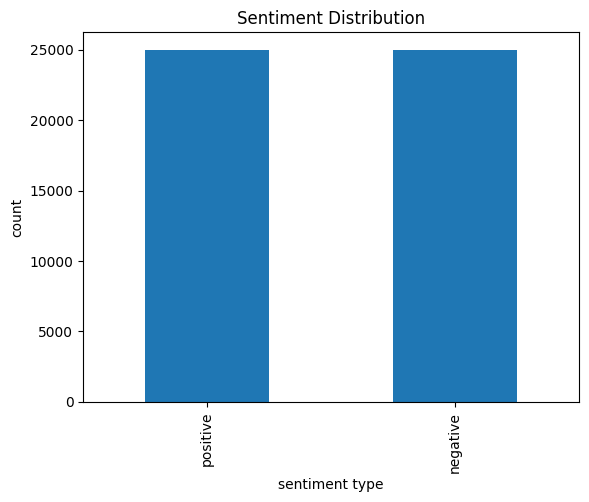

In [364]:
data.sentiment.value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('sentiment type')
plt.ylabel('count')
plt.show

In [365]:
nltk.download('stopwords')
stop_words  = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romirai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [366]:
def clean_reviews(text):

    #cleaning html tags
    regex = re.compile('<.*?>')
    text = re.sub(regex, '',text)

    #removing special characters

    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern, '',text)

    #removing numbers

    pattern = re.compile('\d+')
    text = re.sub(pattern, '', text)

    #converting to lower case

    text = text.lower()

    #tokenize words
    text = word_tokenize(text)

    #stop words removal
    text = [word for word in text if not word in stop_words]

    return text

data['review'] = data['review'].apply(clean_reviews)

In [367]:
data['review']

0        [one, reviewers, mentioned, watching, oz, epis...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, theres, family, little, boy, jake,...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movies, high, art, ...
Name: review, Length: 50000, dtype: object

In [368]:
tokenizer = Tokenizer()
review_to_list = data['review'].to_list()
tokenizer.fit_on_texts(review_to_list)


In [369]:

cells = [np.array(a) for a in tokenizer.texts_to_sequences(review_to_list)]

In [370]:
max_len = 0
for a in range(len(cells)):
    if len(cells[a]) > max_len:
        max_len = len(cells[a])

In [371]:
max_len

1420

In [372]:
max_words = max_len

In [373]:
x = pad_sequences(cells, maxlen=max_words)

In [374]:
y = data[data.columns[1:]]
y

,sentiment
0,positive
1,positive
2,positive
3,negative
4,positive
...,...
49995,positive
49996,negative
49997,negative
49998,negative


In [375]:
labelencoder = LabelEncoder()

In [376]:
sentiments = labelencoder.fit_transform(y)

In [377]:
y_data = np.array(sentiments)

In [378]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_data, test_size=0.2, random_state=42)

In [379]:
# Creating a RNN model 
rnn = Sequential(name="Simple_RNN") 
rnn.add(Embedding(len(tokenizer.word_index)+1, 
						max_words, 
						input_length=max_words)) 

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True)) 

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False)) 

rnn.add(Dense(1, activation='sigmoid')) 




In [380]:
# Compiling model 
rnn.compile( 
	loss="categorical_crossentropy", 
	optimizer='adam', 
	metrics=['accuracy'] 
) 

# Training the model 
history = rnn.fit(x_train, y_train, 
						batch_size=64, 
						epochs=2, 
						verbose=1, 
						validation_data = (x_test, y_test)) 

# Printing model score on test data 
print("Simple_RNN Score---> ", rnn.evaluate(x_test, y_test, verbose=1))


Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 2796s 4s/step - accuracy: 0.5003 - loss: nan - val_accuracy: 0.4961 - val_loss: nan
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 2749s 4s/step - accuracy: 0.4988 - loss: nan - val_accuracy: 0.4961 - val_loss: nan
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 267ms/step - accuracy: 0.4978 - loss: nan
Simple_RNN Score--->  [nan, 0.4961000084877014]


In [385]:
history.history


{'accuracy': [0.5008749961853027, 0.5009750127792358],
 'loss': [nan, nan],
 'val_accuracy': [0.4961000084877014, 0.4961000084877014],
 'val_loss': [nan, nan]}

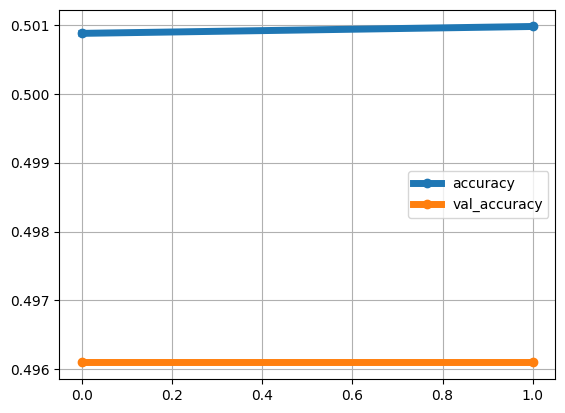

In [398]:
plt.figure()
plt.plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'], linewidth=5, markersize=6, marker='o')
plt.grid(True)

plt.legend(['accuracy','val_accuracy'])

In [400]:
y_pred = rnn.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 290ms/step


array([nan], dtype=float32)